In [2]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path, PurePath

def plot_logs(name,logs, fields=('loss','class_error', 'loss_bbox_unscaled', 'mAP'), ewm_col=0, log_name='log.txt'):
    '''
    Function to plot specific fields from training log(s). Plots both training and test results.

    :: Inputs - logs = list containing Path objects, each pointing to individual dir with a log file
              - fields = which results to plot from each log file - plots both training and test for each field.
              - ewm_col = optional, which column to use as the exponential weighted smoothing of the plots
              - log_name = optional, name of log file if different than default 'log.txt'.

    :: Outputs - matplotlib plots of results in fields, color coded for each log file.
               - solid lines are training results, dashed lines are test results.

    '''
    func_name = "plot_utils.py::plot_logs"

    # verify logs is a list of Paths (list[Paths]) or single Pathlib object Path,
    # convert single Path to list to avoid 'not iterable' error

    if not isinstance(logs, list):
        if isinstance(logs, PurePath):
            logs = [logs]
            print(f"{func_name} info: logs param expects a list argument, converted to list[Path].")
        else:
            raise ValueError(f"{func_name} - invalid argument for logs parameter.\n \
            Expect list[Path] or single Path obj, received {type(logs)}")

    # Quality checks - verify valid dir(s), that every item in list is Path object, and that log_name exists in each dir
    for i, dir in enumerate(logs):
        if not isinstance(dir, PurePath):
            raise ValueError(f"{func_name} - non-Path object in logs argument of {type(dir)}: \n{dir}")
        if not dir.exists():
            raise ValueError(f"{func_name} - invalid directory in logs argument:\n{dir}")
        # verify log_name exists
        fn = Path(dir / log_name)
        if not fn.exists():
            print(f"-> missing {log_name}.  Have you gotten to Epoch 1 in training?")
            print(f"--> full path of missing log file: {fn}")
            return

    # load log file(s) and plot
    dfs = [pd.read_json(Path(p) / log_name, lines=True) for p in logs]

    fig, axs = plt.subplots(ncols=len(fields), figsize=(16, 5))

    for df, color in zip(dfs, sns.color_palette(n_colors=len(logs))):
        for j, field in enumerate(fields):
            if field == 'mAP':
                coco_eval = pd.DataFrame(
                    np.stack(df.test_coco_eval_bbox.dropna().values)[:, 1]
                ).ewm(com=ewm_col).mean()
                axs[j].plot(coco_eval, c=color)
            else:
                df.interpolate().ewm(com=ewm_col).mean().plot(
                    y=[f'train_{field}', f'test_{field}'],
                    ax=axs[j],
                    color=[color] * 2,
                    style=['-', '--']
                )
    for ax, field in zip(axs, fields):
        ax.legend([Path(p).name for p in logs])
        ax.set_title(field)
    plt.savefig(str(name)+".png")

def plot_precision_recall(files, naming_scheme='iter'):
    if naming_scheme == 'exp_id':
        # name becomes exp_id
        names = [f.parts[-3] for f in files]
    elif naming_scheme == 'iter':
        names = [f.stem for f in files]
    else:
        raise ValueError(f'not supported {naming_scheme}')
    fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
    for f, color, name in zip(files, sns.color_palette("Blues", n_colors=len(files)), names):
        data = torch.load(f)
        # precision is n_iou, n_points, n_cat, n_area, max_det
        precision = data['precision']
        recall = data['params'].recThrs
        scores = data['scores']
        # take precision for all classes, all areas and 100 detections
        precision = precision[0, :, :, 0, -1].mean(1)
        scores = scores[0, :, :, 0, -1].mean(1)
        prec = precision.mean()
        rec = data['recall'][0, :, 0, -1].mean()
        print(f'{naming_scheme} {name}: mAP@50={prec * 100: 05.1f}, ' +
              f'score={scores.mean():0.3f}, ' +
              f'f1={2 * prec * rec / (prec + rec + 1e-8):0.3f}'
              )
        axs[0].plot(recall, precision, c=color)
        axs[1].plot(recall, scores, c=color)

    axs[0].set_title('Precision / Recall')
    axs[0].legend(names)
    axs[1].set_title('Scores / Recall')
    axs[1].legend(names)
    return fig, axs


- solid lines are training results, dashed lines are test results.


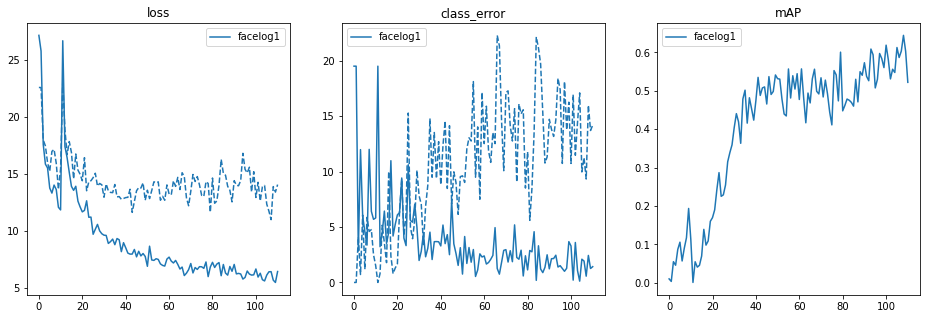

In [3]:
# import util.plot_utils as plot_precision_recall
from pathlib import Path
a = Path('/home/gkalitsios/Desktop/detr/facelog1')
c=[]
c.append(a)
plot_logs(2,c,fields=('loss','class_error', 'mAP'))
print("- solid lines are training results, dashed lines are test results.")

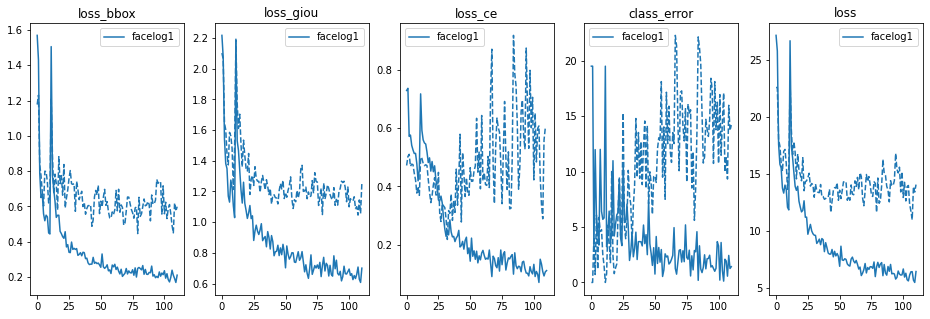

In [4]:
plot_logs(1,c,fields=('loss_bbox','loss_giou','loss_ce','class_error','loss'))

In [ ]:
# import util.plot_utils as plot_precision_recall
from pathlib import Path
a = Path('/home/gkalitsios/Desktop/detr/facelog11')
c=[]
c.append(a)
plot_logs(c,fields=('loss','class_error', 'mAP'))
print("- solid lines are training results, dashed lines are test results.")

In [ ]:
plot_logs(c,fields=('loss_bbox','loss_giou','loss_ce','class_error','loss'))

In [ ]:

# import util.plot_utils as plot_precision_recall
from pathlib import Path
a = Path('/home/gkalitsios/Desktop/detr/facelog11')
c=[]
c.append(a)
plot_logs('log11_1',c,fields=('loss', 'mAP'))
print("- solid lines are training results, dashed lines are test results.")

In [ ]:
plot_logs('log11_2',c,fields=('loss_bbox','loss_giou','loss_ce'))

In [ ]:
plot_logs('log11_3',c,fields=((
    'class_error',
    'cardinality_error_unscaled',
    )))

iter latest: mAP@50= 52.2, score=0.572, f1=0.560
iter 050: mAP@50= 55.7, score=0.599, f1=0.598
iter 000: mAP@50= 00.1, score=0.047, f1=0.002


(<Figure size 1152x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Precision / Recall'}>,
        <AxesSubplot:title={'center':'Scores / Recall'}>], dtype=object))

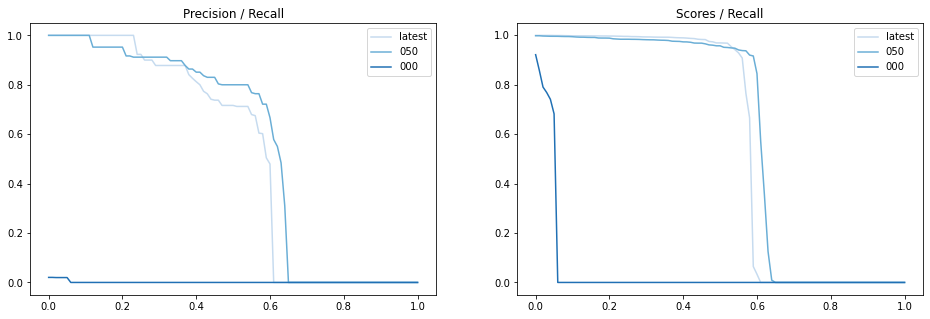

In [5]:
# import util.plot_utils as plot_precision_recall
from pathlib import Path

files = list(Path('/home/gkalitsios/Desktop/detr/facelog1/eval').glob('*.pth'))
plot_precision_recall(files)

In [ ]:
plot_logs(c,fields=('loss_bbox','loss_ce', 'loss_ce_unscaled'))

In [ ]:
plot_logs(c,fields=('loss_ce_unscaled','loss_ce_1_unscaled','loss_ce_2_unscaled', 'loss_ce_3_unscaled', 'loss_ce_4_unscaled'))

In [ ]:
plot_logs(c,fields=('loss_ce_unscaled','loss_ce_1_unscaled',))

In [ ]:
plot_logs(c,fields=('loss_ce_2_unscaled', 'loss_ce_3_unscaled', 'loss_ce_4_unscaled'))

In [ ]:
plot_logs(c,fields=('loss_ce','loss_ce_1','loss_ce_2', 'loss_ce_3', 'loss_ce_4'))

In [ ]:
plot_logs(c,fields=('loss_giou','loss_giou_1','loss_giou_2', 'loss_giou_3', 'loss_giou_4'))

In [ ]:
plot_logs(c,fields=('loss_giou','loss_giou_1'))

In [ ]:
plot_logs(c,fields=('loss_bbox','loss_bbox_1','loss_bbox_2', 'loss_bbox_3', 'loss_bbox_4'))